In [20]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np
from collections import defaultdict

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load file - UPDATE THIS PATH AS NEEDED
filepath = "finetune_evals/delegate_game_2025-12-04-03-44-56_Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_n50_comparison.jsonl"

# Read all lines and extract data
base_summary = None
finetuned_summary = None
base_trials = []
finetuned_trials = []

with open(filepath, 'r') as f:
    for line in f:
        if line.strip():
            entry = json.loads(line.strip())
            entry_type = entry.get('type', '')
            if entry_type == 'base_delegate_game_summary':
                base_summary = entry
            elif entry_type == 'finetuned_delegate_game_summary':
                finetuned_summary = entry
            elif entry_type == 'base_delegate_game_trial':
                base_trials.append(entry)
            elif entry_type == 'finetuned_delegate_game_trial':
                finetuned_trials.append(entry)

print("Loaded delegate game data:")
if base_summary:
    print(f"  ✓ Base model: {base_summary.get('total_phase2_trials', 0)} trials, Accuracy: {base_summary.get('phase2_accuracy', 0):.4f}")
if finetuned_summary:
    print(f"  ✓ Fine-tuned model: {finetuned_summary.get('total_phase2_trials', 0)} trials, Accuracy: {finetuned_summary.get('phase2_accuracy', 0):.4f}")

print(f"\nLoaded trial data:")
print(f"  ✓ Base trials: {len(base_trials)}")
print(f"  ✓ Fine-tuned trials: {len(finetuned_trials)}")

# Extract model and dataset info from filepath
def extract_model_dataset_info(filepath):
    """Extract model and dataset names from filepath."""
    path = Path(filepath)
    filename = path.stem
    
    parts = filename.split('_')
    
    base_model = None
    lora_name = None
    dataset_name = None
    
    # Look for base model
    for i, part in enumerate(parts):
        if 'llama' in part.lower() and 'meta' in part.lower():
            base_model = part
            break
    
    # Look for dataset name
    for i, part in enumerate(parts):
        if part.lower().startswith('popmc') or part.lower().startswith('triviamc') or part.lower().startswith('simplemc'):
            dataset_name = part
            break
    
    # Look for lora name
    for i, part in enumerate(parts):
        if 'metacognition' in part.lower() or 'wbtl' in part.lower() or 'step' in part.lower():
            lora_parts = []
            for j in range(i, min(i+5, len(parts))):
                if parts[j].startswith('n') and parts[j][1:].isdigit():
                    break
                if parts[j].lower() in ['popmc', 'triviamc', 'simplemc', 'comparison']:
                    break
                lora_parts.append(parts[j])
            if lora_parts:
                lora_name = '-'.join(lora_parts)
            break
    
    return base_model, lora_name, dataset_name

base_model, lora_name, dataset_name = extract_model_dataset_info(filepath)

model_display = base_model if base_model else "Unknown Model"
dataset_display = dataset_name if dataset_name else "Unknown Dataset"

print(f"\n📊 Model & Dataset Info (extracted from filename):")
print(f"  Model: {model_display}")
if lora_name:
    print(f"  LoRA Adapter: {lora_name}")
print(f"  Dataset: {dataset_display}")

def add_model_dataset_info(fig, model_display, dataset_display, lora_name=None):
    """Add model and dataset information at the top of a figure."""
    if lora_name:
        title_text = f"{model_display} (Finetuned) | {dataset_display}"
    else:
        title_text = f"{model_display} | {dataset_display}"
    fig.subplots_adjust(top=0.92)
    fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.98, ha='center')

Loaded delegate game data:
  ✓ Base model: 50 trials, Accuracy: 0.6400
  ✓ Fine-tuned model: 50 trials, Accuracy: 0.6400

Loaded trial data:
  ✓ Base trials: 50
  ✓ Fine-tuned trials: 50

📊 Model & Dataset Info (extracted from filename):
  Model: Meta-Llama-3.1-8B-Instruct
  LoRA Adapter: metacognition-wbtl9xqu-step-1280-20251203-224144
  Dataset: PopMC


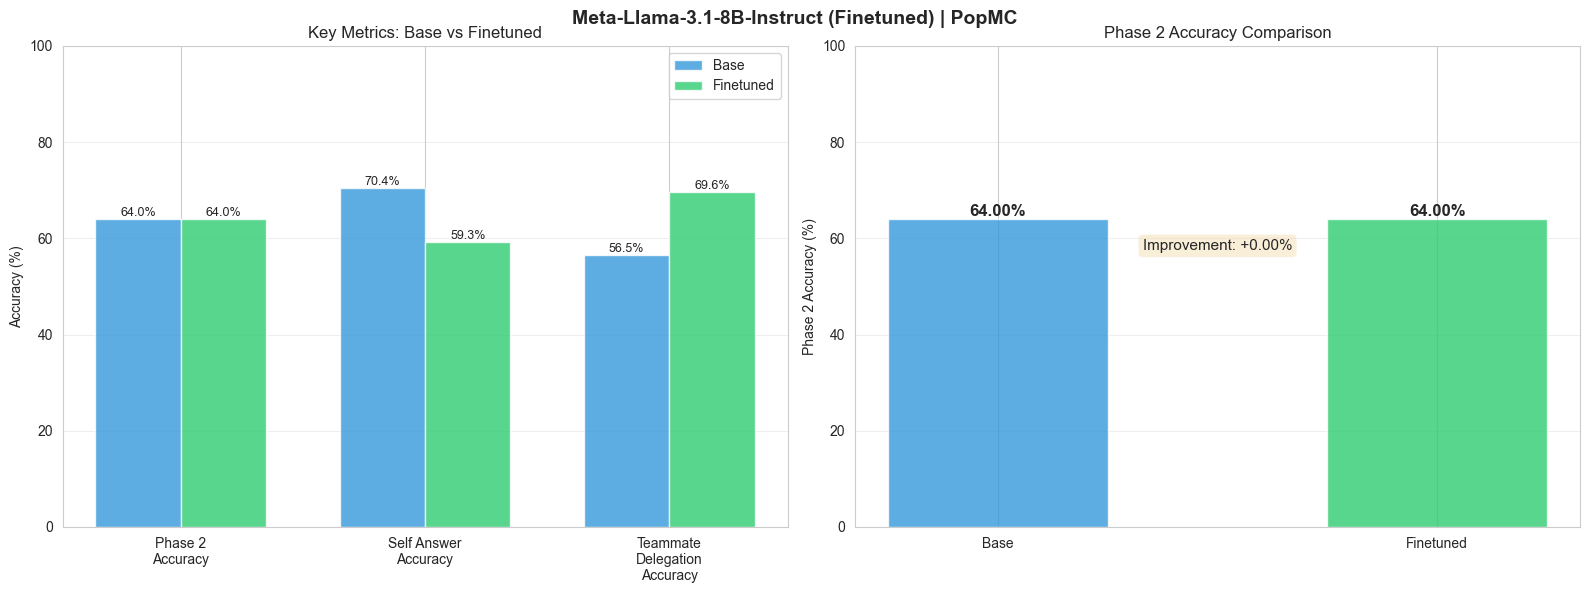


📊 Overall Metrics:
  Phase 2 Accuracy: Base=64.00%, Finetuned=64.00% (Δ=+0.00%)
  Self Answer Accuracy: Base=70.37%, Finetuned=59.26%
  Teammate Delegation Accuracy: Base=56.52%, Finetuned=69.57%


In [21]:
# 1. Overall Metrics Comparison
if base_summary and finetuned_summary:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Key metrics comparison
    metrics = ['Phase 2\nAccuracy', 'Self Answer\nAccuracy', 'Teammate\nDelegation\nAccuracy']
    base_vals = [
        base_summary.get('phase2_accuracy', 0) * 100,
        base_summary.get('self_answer_accuracy', 0) * 100,
        base_summary.get('teammate_delegation_accuracy', 0) * 100
    ]
    finetuned_vals = [
        finetuned_summary.get('phase2_accuracy', 0) * 100,
        finetuned_summary.get('self_answer_accuracy', 0) * 100,
        finetuned_summary.get('teammate_delegation_accuracy', 0) * 100
    ]
    
    x = range(len(metrics))
    width = 0.35
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], base_vals, width, label='Base', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], finetuned_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Key Metrics: Base vs Finetuned')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics, rotation=0, ha='center')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 100)
    
    # Add value labels
    for i, (base_val, fin_val) in enumerate(zip(base_vals, finetuned_vals)):
        ax1.text(i - width/2, base_val, f'{base_val:.1f}%', ha='center', va='bottom', fontsize=9)
        ax1.text(i + width/2, fin_val, f'{fin_val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Right: Phase 2 accuracy comparison
    ax2 = axes[1]
    models = ['Base', 'Finetuned']
    accuracies = [base_summary.get('phase2_accuracy', 0) * 100, finetuned_summary.get('phase2_accuracy', 0) * 100]
    colors = ['#3498db', '#2ecc71']
    bars = ax2.bar(models, accuracies, color=colors, alpha=0.8, width=0.5)
    ax2.set_ylabel('Phase 2 Accuracy (%)')
    ax2.set_title('Phase 2 Accuracy Comparison')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels and improvement
    for bar, acc in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2., acc,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    improvement = accuracies[1] - accuracies[0]
    ax2.text(0.5, max(accuracies) * 0.9, f'Improvement: {improvement:+.2f}%',
            ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Overall Metrics:")
    print(f"  Phase 2 Accuracy: Base={accuracies[0]:.2f}%, Finetuned={accuracies[1]:.2f}% (Δ={improvement:+.2f}%)")
    print(f"  Self Answer Accuracy: Base={base_vals[1]:.2f}%, Finetuned={finetuned_vals[1]:.2f}%")
    print(f"  Teammate Delegation Accuracy: Base={base_vals[2]:.2f}%, Finetuned={finetuned_vals[2]:.2f}%")


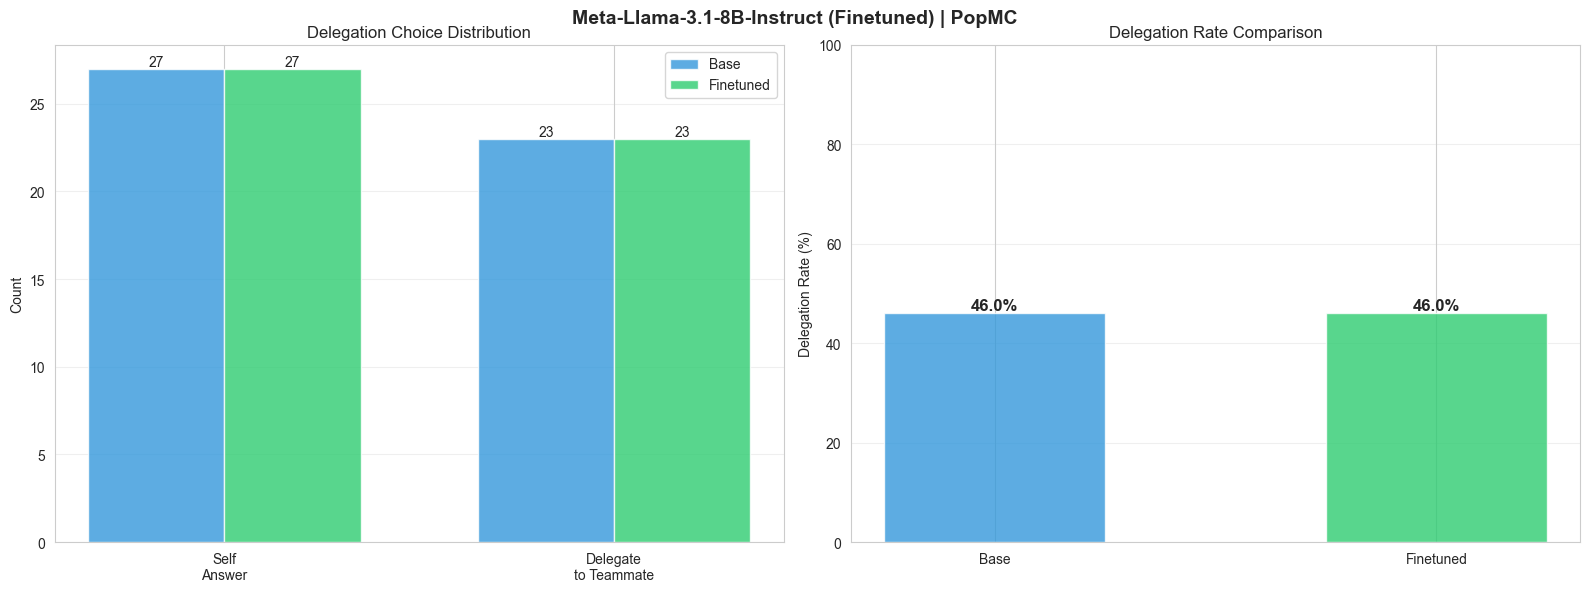


📊 Delegation Analysis:
  Base: 27 self-answers, 23 delegations (46.0% delegation rate)
  Finetuned: 27 self-answers, 23 delegations (46.0% delegation rate)
  Change in delegation rate: +0.0%


In [22]:
# 2. Delegation Rate Analysis
if base_summary and finetuned_summary:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Delegation counts
    base_delegations = base_summary.get('delegations_to_teammate', 0)
    base_self_answers = base_summary.get('self_answers', 0)
    finetuned_delegations = finetuned_summary.get('delegations_to_teammate', 0)
    finetuned_self_answers = finetuned_summary.get('self_answers', 0)
    
    ax1 = axes[0]
    categories = ['Self\nAnswer', 'Delegate\nto Teammate']
    base_counts = [base_self_answers, base_delegations]
    finetuned_counts = [finetuned_self_answers, finetuned_delegations]
    
    x = range(len(categories))
    width = 0.35
    ax1.bar([i - width/2 for i in x], base_counts, width, label='Base', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], finetuned_counts, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Count')
    ax1.set_title('Delegation Choice Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (base_count, fin_count) in enumerate(zip(base_counts, finetuned_counts)):
        ax1.text(i - width/2, base_count, f'{base_count}', ha='center', va='bottom', fontsize=10)
        ax1.text(i + width/2, fin_count, f'{fin_count}', ha='center', va='bottom', fontsize=10)
    
    # Right: Delegation rates
    ax2 = axes[1]
    base_delegation_rate = base_delegations / (base_delegations + base_self_answers) * 100 if (base_delegations + base_self_answers) > 0 else 0
    finetuned_delegation_rate = finetuned_delegations / (finetuned_delegations + finetuned_self_answers) * 100 if (finetuned_delegations + finetuned_self_answers) > 0 else 0
    
    models = ['Base', 'Finetuned']
    rates = [base_delegation_rate, finetuned_delegation_rate]
    colors = ['#3498db', '#2ecc71']
    bars = ax2.bar(models, rates, color=colors, alpha=0.8, width=0.5)
    ax2.set_ylabel('Delegation Rate (%)')
    ax2.set_title('Delegation Rate Comparison')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        ax2.text(bar.get_x() + bar.get_width()/2., rate,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Delegation Analysis:")
    print(f"  Base: {base_self_answers} self-answers, {base_delegations} delegations ({base_delegation_rate:.1f}% delegation rate)")
    print(f"  Finetuned: {finetuned_self_answers} self-answers, {finetuned_delegations} delegations ({finetuned_delegation_rate:.1f}% delegation rate)")
    print(f"  Change in delegation rate: {finetuned_delegation_rate - base_delegation_rate:+.1f}%")


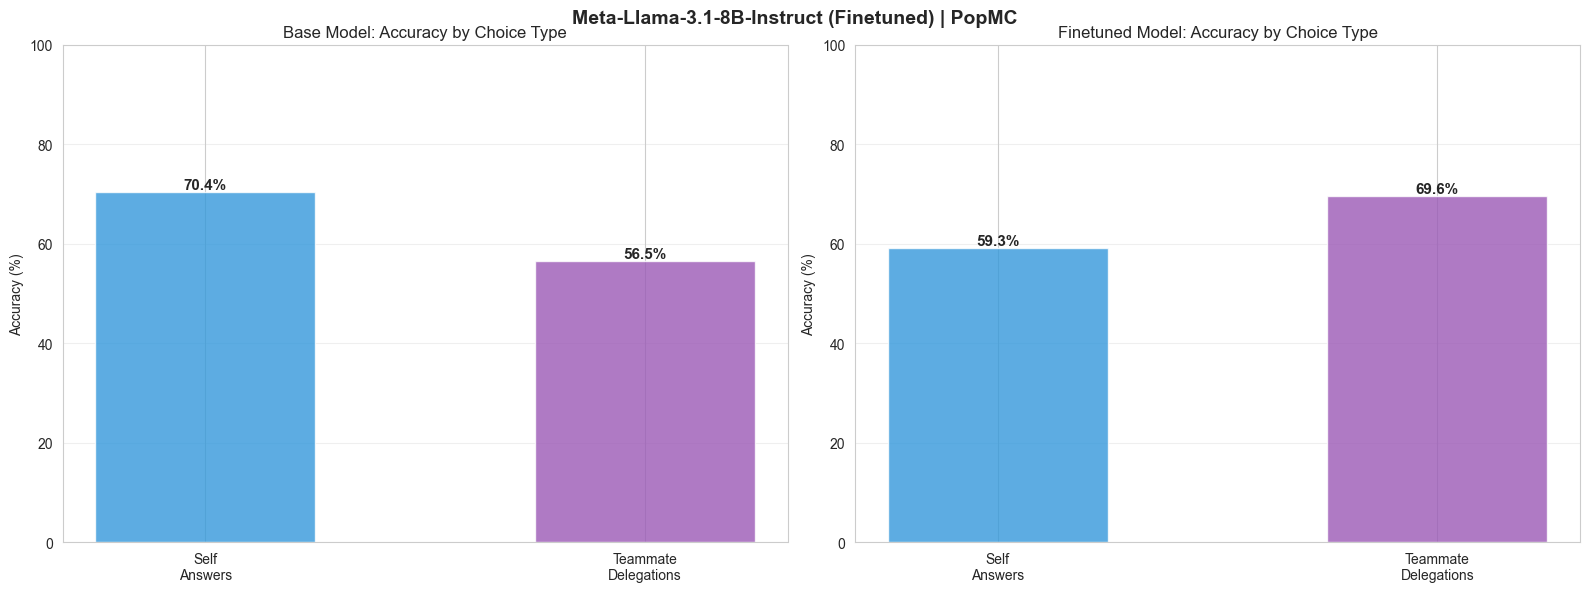


📊 Accuracy Breakdown:
  Base Model:
    Self-answers: 70.37%
    Teammate delegations: 56.52%
  Finetuned Model:
    Self-answers: 59.26%
    Teammate delegations: 69.57%


In [23]:
# 3. Self vs Teammate Accuracy Breakdown
if base_summary and finetuned_summary:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Base model breakdown
    base_self_acc = base_summary.get('self_answer_accuracy', 0) * 100
    base_teammate_acc = base_summary.get('teammate_delegation_accuracy', 0) * 100
    
    ax1 = axes[0]
    categories = ['Self\nAnswers', 'Teammate\nDelegations']
    accs = [base_self_acc, base_teammate_acc]
    colors = ['#3498db', '#9b59b6']
    bars1 = ax1.bar(categories, accs, color=colors, alpha=0.8, width=0.5)
    ax1.set_ylabel('Accuracy (%)')
    ax1.set_title('Base Model: Accuracy by Choice Type')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars1, accs):
        ax1.text(bar.get_x() + bar.get_width()/2., acc,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Right: Finetuned model breakdown
    finetuned_self_acc = finetuned_summary.get('self_answer_accuracy', 0) * 100
    finetuned_teammate_acc = finetuned_summary.get('teammate_delegation_accuracy', 0) * 100
    
    ax2 = axes[1]
    accs2 = [finetuned_self_acc, finetuned_teammate_acc]
    bars2 = ax2.bar(categories, accs2, color=colors, alpha=0.8, width=0.5)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Finetuned Model: Accuracy by Choice Type')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    for bar, acc in zip(bars2, accs2):
        ax2.text(bar.get_x() + bar.get_width()/2., acc,
                f'{acc:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Accuracy Breakdown:")
    print(f"  Base Model:")
    print(f"    Self-answers: {base_self_acc:.2f}%")
    print(f"    Teammate delegations: {base_teammate_acc:.2f}%")
    print(f"  Finetuned Model:")
    print(f"    Self-answers: {finetuned_self_acc:.2f}%")
    print(f"    Teammate delegations: {finetuned_teammate_acc:.2f}%")


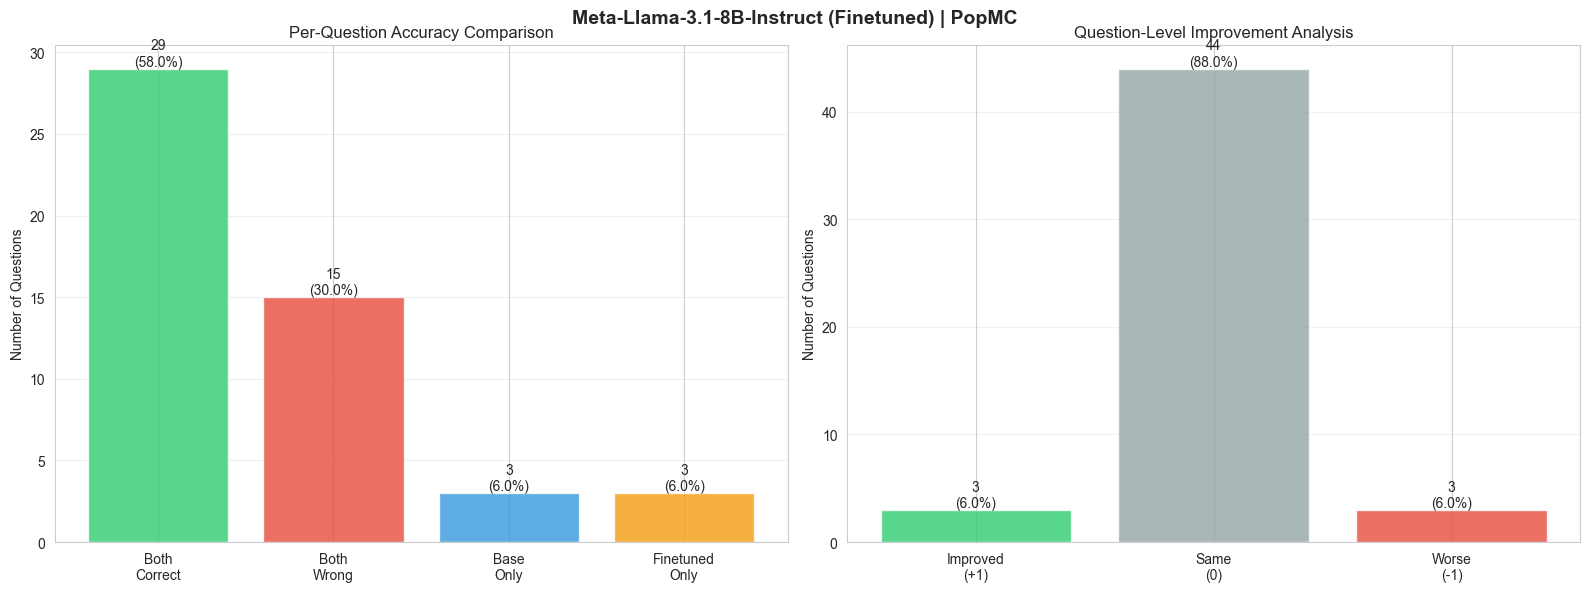


📊 Per-Question Analysis:
   Total questions: 50
   Both correct: 29 (58.0%)
   Both wrong: 15 (30.0%)
   Improved (wrong→correct): 3 (6.0%)
   Regressed (correct→wrong): 3 (6.0%)
   Net improvement: 0 questions


In [24]:
# 4. Per-Question Comparison
if len(base_trials) > 0 and len(finetuned_trials) > 0:
    # Create DataFrames
    base_df = pd.DataFrame(base_trials)
    finetuned_df = pd.DataFrame(finetuned_trials)
    
    # Match by question_id
    base_df['is_correct'] = base_df['team_correct'].fillna(False)
    finetuned_df['is_correct'] = finetuned_df['team_correct'].fillna(False)
    
    merged = base_df[['question_id', 'is_correct', 'delegation_choice']].merge(
        finetuned_df[['question_id', 'is_correct', 'delegation_choice']], 
        on='question_id', 
        suffixes=('_base', '_finetuned')
    )
    
    # Categorize questions
    both_correct = (merged['is_correct_base'] & merged['is_correct_finetuned']).sum()
    both_wrong = ((~merged['is_correct_base']) & (~merged['is_correct_finetuned'])).sum()
    base_only = (merged['is_correct_base'] & (~merged['is_correct_finetuned'])).sum()
    finetuned_only = ((~merged['is_correct_base']) & merged['is_correct_finetuned']).sum()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Question outcome categories
    ax1 = axes[0]
    categories = ['Both\nCorrect', 'Both\nWrong', 'Base\nOnly', 'Finetuned\nOnly']
    counts = [both_correct, both_wrong, base_only, finetuned_only]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
    bars = ax1.bar(categories, counts, color=colors, alpha=0.8)
    ax1.set_ylabel('Number of Questions')
    ax1.set_title('Per-Question Accuracy Comparison')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2., count,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    # Right: Improvement breakdown
    ax2 = axes[1]
    improvement_categories = ['Improved\n(+1)', 'Same\n(0)', 'Worse\n(-1)']
    improvement_counts = [
        finetuned_only,  # Improved: wrong -> correct
        both_correct + both_wrong,  # Same: both correct or both wrong
        base_only  # Worse: correct -> wrong
    ]
    improvement_colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    bars2 = ax2.bar(improvement_categories, improvement_counts, color=improvement_colors, alpha=0.8)
    ax2.set_ylabel('Number of Questions')
    ax2.set_title('Question-Level Improvement Analysis')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars2, improvement_counts):
        ax2.text(bar.get_x() + bar.get_width()/2., count,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Per-Question Analysis:")
    print(f"   Total questions: {len(merged)}")
    print(f"   Both correct: {both_correct} ({both_correct/len(merged)*100:.1f}%)")
    print(f"   Both wrong: {both_wrong} ({both_wrong/len(merged)*100:.1f}%)")
    print(f"   Improved (wrong→correct): {finetuned_only} ({finetuned_only/len(merged)*100:.1f}%)")
    print(f"   Regressed (correct→wrong): {base_only} ({base_only/len(merged)*100:.1f}%)")
    print(f"   Net improvement: {finetuned_only - base_only} questions")


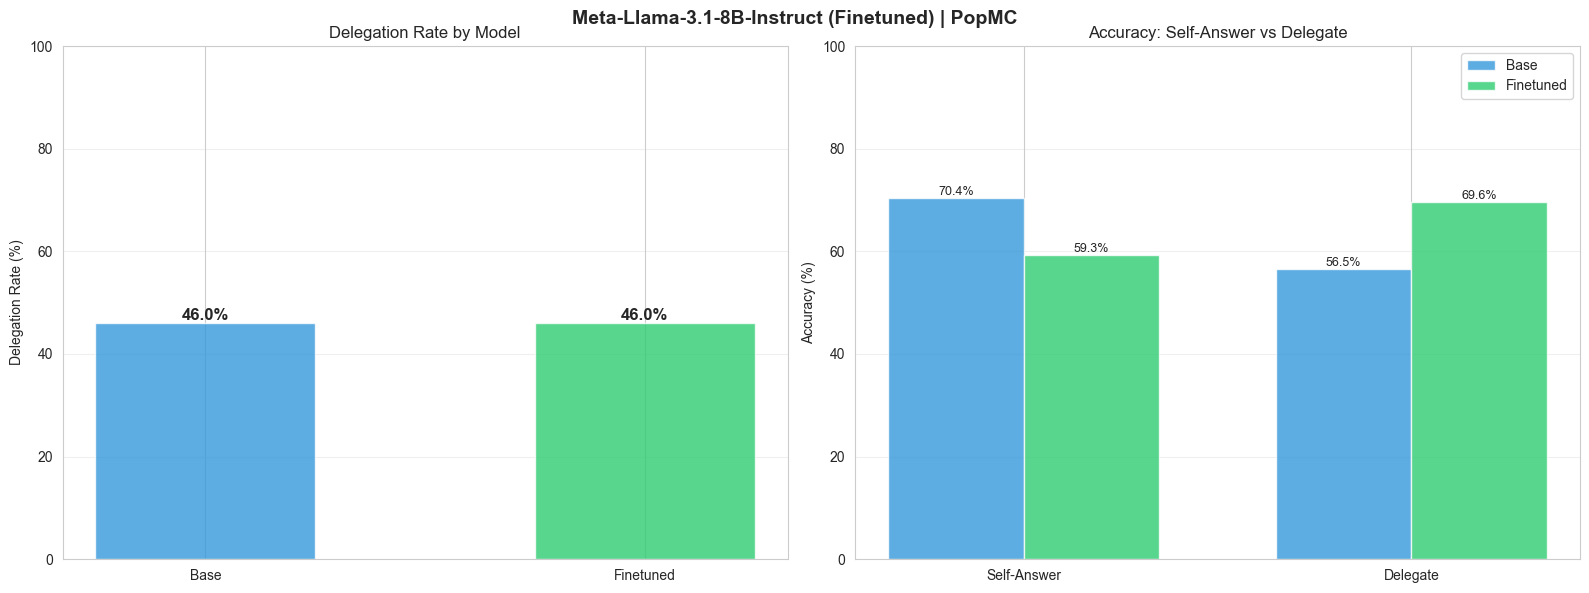


📊 Delegation Patterns:
  Base Model:
    Delegation rate: 46.0% (23 delegations, 27 self-answers)
    Self-answer accuracy: 70.4%
    Teammate delegation accuracy: 56.5%
  Finetuned Model:
    Delegation rate: 46.0% (23 delegations, 27 self-answers)
    Self-answer accuracy: 59.3%
    Teammate delegation accuracy: 69.6%


In [25]:
# 5. Delegation Choice by Question Correctness
if len(base_trials) > 0 and len(finetuned_trials) > 0:
    base_df = pd.DataFrame(base_trials)
    finetuned_df = pd.DataFrame(finetuned_trials)
    
    # For base model: check if they would have been correct (from capabilities)
    # We'll use team_correct as proxy since we don't have capabilities data here
    # Actually, let's analyze delegation patterns
    
    def analyze_delegation_patterns(df, model_name):
        """Analyze when model delegates vs self-answers."""
        df['delegated'] = df['delegation_choice'] == 'Teammate'
        df['self_answered'] = df['delegation_choice'] == 'Self'
        
        # When self-answered, was it correct?
        self_answered = df[df['self_answered']]
        self_correct_rate = self_answered['team_correct'].mean() if len(self_answered) > 0 else 0
        
        # When delegated, was teammate correct?
        delegated = df[df['delegated']]
        teammate_correct_rate = delegated['team_correct'].mean() if len(delegated) > 0 else 0
        
        return {
            'delegation_rate': df['delegated'].mean(),
            'self_correct_rate': self_correct_rate,
            'teammate_correct_rate': teammate_correct_rate,
            'n_self': len(self_answered),
            'n_delegate': len(delegated)
        }
    
    base_patterns = analyze_delegation_patterns(base_df, 'Base')
    finetuned_patterns = analyze_delegation_patterns(finetuned_df, 'Finetuned')
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Delegation rates
    ax1 = axes[0]
    models = ['Base', 'Finetuned']
    delegation_rates = [base_patterns['delegation_rate'] * 100, finetuned_patterns['delegation_rate'] * 100]
    colors = ['#3498db', '#2ecc71']
    bars = ax1.bar(models, delegation_rates, color=colors, alpha=0.8, width=0.5)
    ax1.set_ylabel('Delegation Rate (%)')
    ax1.set_title('Delegation Rate by Model')
    ax1.set_ylim(0, 100)
    ax1.grid(axis='y', alpha=0.3)
    
    for bar, rate in zip(bars, delegation_rates):
        ax1.text(bar.get_x() + bar.get_width()/2., rate,
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Right: Accuracy when self-answering vs delegating
    ax2 = axes[1]
    x = range(2)
    width = 0.35
    
    base_accs = [base_patterns['self_correct_rate'] * 100, base_patterns['teammate_correct_rate'] * 100]
    finetuned_accs = [finetuned_patterns['self_correct_rate'] * 100, finetuned_patterns['teammate_correct_rate'] * 100]
    
    ax2.bar([i - width/2 for i in x], base_accs, width, label='Base', color='#3498db', alpha=0.8)
    ax2.bar([i + width/2 for i in x], finetuned_accs, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy: Self-Answer vs Delegate')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Self-Answer', 'Delegate'])
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 100)
    
    # Add value labels
    for i, (base_acc, fin_acc) in enumerate(zip(base_accs, finetuned_accs)):
        ax2.text(i - width/2, base_acc, f'{base_acc:.1f}%', ha='center', va='bottom', fontsize=9)
        ax2.text(i + width/2, fin_acc, f'{fin_acc:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Delegation Patterns:")
    print(f"  Base Model:")
    print(f"    Delegation rate: {base_patterns['delegation_rate']*100:.1f}% ({base_patterns['n_delegate']} delegations, {base_patterns['n_self']} self-answers)")
    print(f"    Self-answer accuracy: {base_patterns['self_correct_rate']*100:.1f}%")
    print(f"    Teammate delegation accuracy: {base_patterns['teammate_correct_rate']*100:.1f}%")
    print(f"  Finetuned Model:")
    print(f"    Delegation rate: {finetuned_patterns['delegation_rate']*100:.1f}% ({finetuned_patterns['n_delegate']} delegations, {finetuned_patterns['n_self']} self-answers)")
    print(f"    Self-answer accuracy: {finetuned_patterns['self_correct_rate']*100:.1f}%")
    print(f"    Teammate delegation accuracy: {finetuned_patterns['teammate_correct_rate']*100:.1f}%")


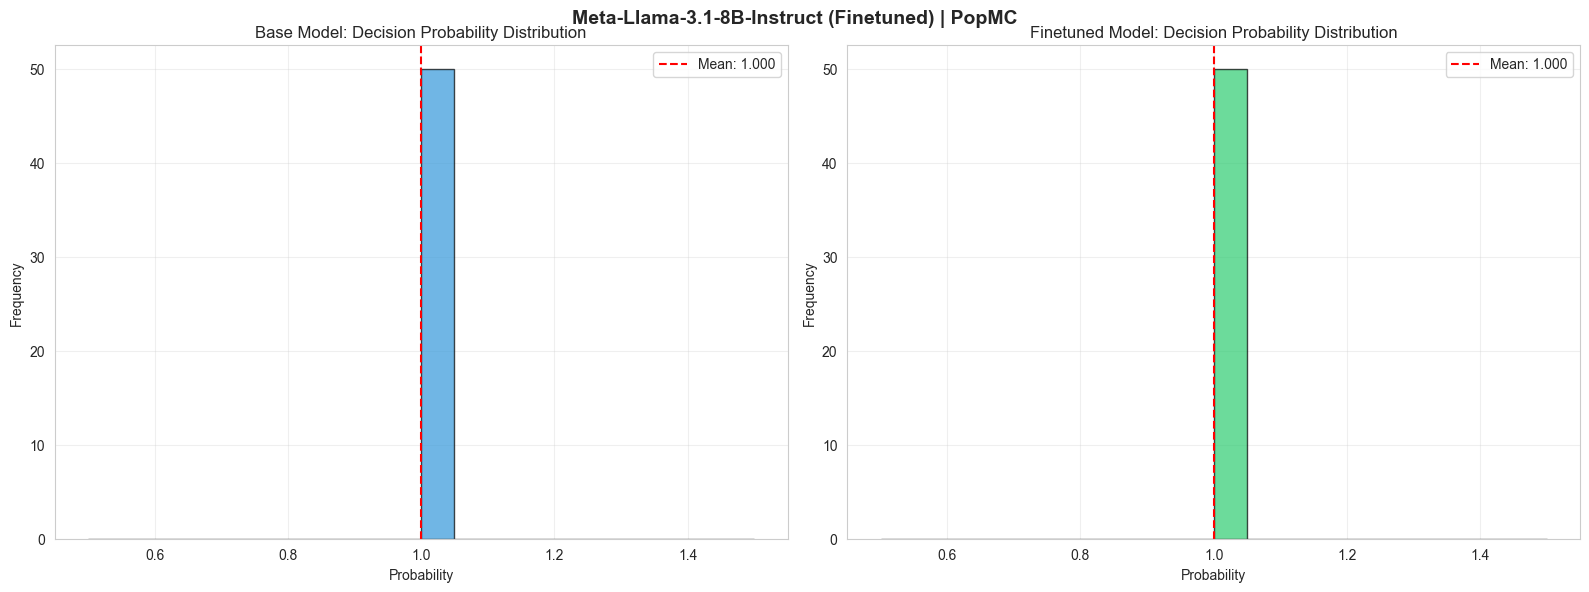


📊 Probability Analysis:
  Base model: Mean prob = 1.000, Std = 0.000
  Finetuned model: Mean prob = 1.000, Std = 0.000


In [26]:
# 6. Probability Distributions (if available)
if len(base_trials) > 0 and len(finetuned_trials) > 0:
    base_df = pd.DataFrame(base_trials)
    finetuned_df = pd.DataFrame(finetuned_trials)
    
    # Extract probabilities for delegation choice
    def extract_delegation_probs(df):
        """Extract probabilities for delegation choices."""
        probs = []
        for _, row in df.iterrows():
            prob_dict = row.get('probs', {})
            if isinstance(prob_dict, dict):
                # Get probability of chosen option
                delegation = row.get('delegation_choice', '')
                if delegation == 'Teammate' and 'D' in prob_dict:  # Assuming 'D' is delegate
                    probs.append(prob_dict.get('D', 0))
                elif delegation == 'Self' and prob_dict:
                    # Get max prob for self-answer options (A, B, C)
                    self_probs = [v for k, v in prob_dict.items() if k in ['A', 'B', 'C']]
                    if self_probs:
                        probs.append(max(self_probs))
        return probs
    
    base_probs = extract_delegation_probs(base_df)
    finetuned_probs = extract_delegation_probs(finetuned_df)
    
    if base_probs and finetuned_probs:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Left: Base model probability distribution
        ax1 = axes[0]
        ax1.hist(base_probs, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
        ax1.axvline(np.mean(base_probs), color='red', linestyle='--', 
                    label=f'Mean: {np.mean(base_probs):.3f}')
        ax1.set_xlabel('Probability')
        ax1.set_ylabel('Frequency')
        ax1.set_title('Base Model: Decision Probability Distribution')
        ax1.legend()
        ax1.grid(alpha=0.3)
        
        # Right: Finetuned model probability distribution
        ax2 = axes[1]
        ax2.hist(finetuned_probs, bins=20, alpha=0.7, color='#2ecc71', edgecolor='black')
        ax2.axvline(np.mean(finetuned_probs), color='red', linestyle='--',
                    label=f'Mean: {np.mean(finetuned_probs):.3f}')
        ax2.set_xlabel('Probability')
        ax2.set_ylabel('Frequency')
        ax2.set_title('Finetuned Model: Decision Probability Distribution')
        ax2.legend()
        ax2.grid(alpha=0.3)
        
        plt.tight_layout()
        add_model_dataset_info(fig, model_display, dataset_display, lora_name)
        plt.show()
        
        print(f"\n📊 Probability Analysis:")
        print(f"  Base model: Mean prob = {np.mean(base_probs):.3f}, Std = {np.std(base_probs):.3f}")
        print(f"  Finetuned model: Mean prob = {np.mean(finetuned_probs):.3f}, Std = {np.std(finetuned_probs):.3f}")
    else:
        print("⚠️  Probability data not available in expected format")


In [27]:
# 7. Summary Statistics Table
if base_summary and finetuned_summary:
    comparison_data = {
        'Metric': [
            'Phase 2 Accuracy (%)',
            'Phase 2 Score',
            'Total Phase 2 Trials',
            'Delegations to Teammate',
            'Self Answers',
            'Self Answer Accuracy (%)',
            'Teammate Delegation Accuracy (%)',
            'Phase 1 Trials',
            'Teammate Accuracy Phase 1',
            'Teammate Accuracy Phase 2',
            'Decision Only Mode',
            'Use Phase 1 Summary',
            'Use Phase 1 History',
            'Temperature',
            'Seed'
        ],
        'Base': [
            f"{base_summary.get('phase2_accuracy', 0) * 100:.2f}%",
            f"{base_summary.get('phase2_score', 0)}",
            f"{base_summary.get('total_phase2_trials', 0)}",
            f"{base_summary.get('delegations_to_teammate', 0)}",
            f"{base_summary.get('self_answers', 0)}",
            f"{base_summary.get('self_answer_accuracy', 0) * 100:.2f}%",
            f"{base_summary.get('teammate_delegation_accuracy', 0) * 100:.2f}%",
            f"{base_summary.get('n_trials_phase1', 0)}",
            f"{base_summary.get('teammate_accuracy_phase1', 0):.2f}",
            f"{base_summary.get('teammate_accuracy_phase2', 0):.2f}",
            f"{base_summary.get('decision_only', False)}",
            f"{base_summary.get('use_phase1_summary', False)}",
            f"{base_summary.get('use_phase1_history', False)}",
            f"{base_summary.get('temperature', 0):.1f}",
            f"{base_summary.get('seed', 0)}"
        ],
        'Finetuned': [
            f"{finetuned_summary.get('phase2_accuracy', 0) * 100:.2f}%",
            f"{finetuned_summary.get('phase2_score', 0)}",
            f"{finetuned_summary.get('total_phase2_trials', 0)}",
            f"{finetuned_summary.get('delegations_to_teammate', 0)}",
            f"{finetuned_summary.get('self_answers', 0)}",
            f"{finetuned_summary.get('self_answer_accuracy', 0) * 100:.2f}%",
            f"{finetuned_summary.get('teammate_delegation_accuracy', 0) * 100:.2f}%",
            f"{finetuned_summary.get('n_trials_phase1', 0)}",
            f"{finetuned_summary.get('teammate_accuracy_phase1', 0):.2f}",
            f"{finetuned_summary.get('teammate_accuracy_phase2', 0):.2f}",
            f"{finetuned_summary.get('decision_only', False)}",
            f"{finetuned_summary.get('use_phase1_summary', False)}",
            f"{finetuned_summary.get('use_phase1_history', False)}",
            f"{finetuned_summary.get('temperature', 0):.1f}",
            f"{finetuned_summary.get('seed', 0)}"
        ],
        'Improvement': [
            f"{((finetuned_summary.get('phase2_accuracy', 0) - base_summary.get('phase2_accuracy', 0)) * 100):+.2f}%",
            f"{(finetuned_summary.get('phase2_score', 0) - base_summary.get('phase2_score', 0)):+d}",
            f"{(finetuned_summary.get('total_phase2_trials', 0) - base_summary.get('total_phase2_trials', 0)):+d}",
            f"{(finetuned_summary.get('delegations_to_teammate', 0) - base_summary.get('delegations_to_teammate', 0)):+d}",
            f"{(finetuned_summary.get('self_answers', 0) - base_summary.get('self_answers', 0)):+d}",
            f"{((finetuned_summary.get('self_answer_accuracy', 0) - base_summary.get('self_answer_accuracy', 0)) * 100):+.2f}%",
            f"{((finetuned_summary.get('teammate_delegation_accuracy', 0) - base_summary.get('teammate_delegation_accuracy', 0)) * 100):+.2f}%",
            f"{(finetuned_summary.get('n_trials_phase1', 0) - base_summary.get('n_trials_phase1', 0)):+d}",
            f"{(finetuned_summary.get('teammate_accuracy_phase1', 0) - base_summary.get('teammate_accuracy_phase1', 0)):+.2f}",
            f"{(finetuned_summary.get('teammate_accuracy_phase2', 0) - base_summary.get('teammate_accuracy_phase2', 0)):+.2f}",
            "—",
            "—",
            "—",
            "—",
            "—"
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("DELEGATE GAME SUMMARY COMPARISON")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # Highlight key improvements
    acc_improvement = (finetuned_summary.get('phase2_accuracy', 0) - base_summary.get('phase2_accuracy', 0)) * 100
    print(f"\n🎯 Key Improvement: Phase 2 Accuracy increased by {acc_improvement:+.2f}%")
    print(f"   Base: {base_summary.get('phase2_accuracy', 0) * 100:.2f}% → Finetuned: {finetuned_summary.get('phase2_accuracy', 0) * 100:.2f}%")



DELEGATE GAME SUMMARY COMPARISON
                          Metric   Base Finetuned Improvement
            Phase 2 Accuracy (%) 64.00%    64.00%      +0.00%
                   Phase 2 Score     32        32          +0
            Total Phase 2 Trials     50        50          +0
         Delegations to Teammate     23        23          +0
                    Self Answers     27        27          +0
        Self Answer Accuracy (%) 70.37%    59.26%     -11.11%
Teammate Delegation Accuracy (%) 56.52%    69.57%     +13.04%
                  Phase 1 Trials     50        50          +0
       Teammate Accuracy Phase 1   0.60      0.60       +0.00
       Teammate Accuracy Phase 2   0.60      0.60       +0.00
              Decision Only Mode   True      True           —
             Use Phase 1 Summary  False     False           —
             Use Phase 1 History   True      True           —
                     Temperature    1.0       1.0           —
                            Seed    